In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

In [2]:
print(tf.__version__)
print(sys.version)
print(tf.config.list_physical_devices("GPU"))

2.10.0
3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_data_dir = r"D:\CNNtest\MAIN_WORK_FOLDER\Working_Data\new plates\train"
valid_data_dir = r"D:\CNNtest\MAIN_WORK_FOLDER\Working_Data\new plates\valid"
test_data_dir = r"D:\CNNtest\MAIN_WORK_FOLDER\Working_Data\new plates\test"

# Pre-Processing Images as Tensor DataSet With Data Augmentation and Without data Augmentaion

In [4]:
train_ds_244 = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                           label_mode="categorical",
                                                           shuffle=True, 
                                                           image_size=(224,224), 
                                                           batch_size=32)

valid_ds_224 = tf.keras.utils.image_dataset_from_directory(valid_data_dir, 
                                                           label_mode="categorical", 
                                                           shuffle=True, 
                                                           image_size=(224,224), 
                                                           batch_size=32)

test_ds_224 = tf.keras.utils.image_dataset_from_directory(test_data_dir, 
                                                          label_mode="categorical", 
                                                          shuffle=True, 
                                                          image_size=(224,224), 
                                                          batch_size=32)

train_ds_fg = tf.keras.utils.image_dataset_from_directory(train_data_dir, 
                                                          label_mode="categorical", 
                                                          shuffle=True, 
                                                          batch_size=None)

Found 8161 files belonging to 56 classes.
Found 280 files belonging to 56 classes.
Found 280 files belonging to 56 classes.
Found 8161 files belonging to 56 classes.


In [5]:
AUGMEN_FACTOR = 0.15

data_augmen_model = tf.keras.models.Sequential([tf.keras.layers.RandomRotation(AUGMEN_FACTOR), 
                                                tf.keras.layers.RandomContrast(AUGMEN_FACTOR), 
                                                tf.keras.layers.RandomFlip("horizontal"), 
                                                tf.keras.layers.Resizing(224,224)])

In [6]:
train_ds_aug = train_ds_fg.map(map_func=lambda x,y:(data_augmen_model(x,training=True),y), 
                               num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_ds_aug = train_ds_aug.batch(32)

# Creating Required Callbacks

In [5]:
def create_tensorboard_callback(extra_name):
    file_path = "D:\\CNNtest\\MAIN_WORK_FOLDER\\Number_Plate_Question\\TensorBoardCallback\\" + extra_name
    callback_obj = tf.keras.callbacks.TensorBoard(log_dir=file_path, 
                                                  update_freq="epoch")
    print(f"Created TensorBoard Callback :- {file_path}")
    return callback_obj

In [6]:
def create_modelsave_callback(extra_name):
    file_path = "D:\\CNNtest\\MAIN_WORK_FOLDER\\Number_Plate_Question\\ModelSaveCheckPoints\\" + extra_name + "\\_{epoch:02d}.ckpt"
    callback_obj = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                      save_weights_only=True, 
                                                      save_freq="epoch", 
                                                      verbose=1)
    return callback_obj

# Creating and Fitting the First Simple Model(model0)

In [10]:
base_model0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model0.trainable = False

In [11]:
base_model0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [12]:
input_layer0 = tf.keras.Input(shape=(224,224,3))

x = base_model0(input_layer0,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

output_layer0 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [13]:
model0 = tf.keras.Model(input_layer0,output_layer0)

In [14]:
model0.compile(loss="categorical_crossentropy", 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [15]:
model0.fit(train_ds_244, 
           epochs=25, 
           steps_per_epoch=len(train_ds_244), 
           validation_data=valid_ds_224, 
           validation_steps=len(valid_ds_224), 
           callbacks=[create_tensorboard_callback("Model0"),
                      create_modelsave_callback("Model0")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model0
Epoch 1/25
256/256 [==============================] - ETA: 0s - loss: 3.3481 - accuracy: 0.2383
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model0\_01.ckpt
256/256 [==============================] - 25s 70ms/step - loss: 3.3481 - accuracy: 0.2383 - val_loss: 2.8771 - val_accuracy: 0.3286
Epoch 2/25
255/256 [============================>.] - ETA: 0s - loss: 2.4980 - accuracy: 0.4498
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model0\_02.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 2.4978 - accuracy: 0.4498 - val_loss: 2.4709 - val_accuracy: 0.4036
Epoch 3/25
255/256 [============================>.] - ETA: 0s - loss: 2.1079 - accuracy: 0.5337
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model0\_03.ckpt
2

# Creating and Fitting Same Simple Model(model1) as(model0) but trained with Augmentated Data

In [16]:
base_model1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model1.trainable = False

In [17]:
base_model1.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [19]:
input_layer1 = tf.keras.Input(shape=(224,224,3))

x = base_model1(input_layer1,training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

output_layer1 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [20]:
model1 = tf.keras.Model(input_layer1,output_layer1)

In [21]:
model1.compile(loss="categorical_crossentropy", 
               optimizer=tf.keras.optimizers.Adam(), 
               metrics=["accuracy"])

In [23]:
model1.fit(train_ds_aug,
           epochs=25, 
           steps_per_epoch=len(train_ds_aug), 
           validation_data=valid_ds_224, 
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model1"),
                      create_modelsave_callback("Model1")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model1
Epoch 1/25
256/256 [==============================] - ETA: 0s - loss: 3.4476 - accuracy: 0.1989
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model1\_01.ckpt
256/256 [==============================] - 24s 72ms/step - loss: 3.4476 - accuracy: 0.1989 - val_loss: 3.2261 - val_accuracy: 0.2464
Epoch 2/25
256/256 [==============================] - ETA: 0s - loss: 2.7471 - accuracy: 0.3708
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model1\_02.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 2.7471 - accuracy: 0.3708 - val_loss: 2.9041 - val_accuracy: 0.3286
Epoch 3/25
256/256 [==============================] - ETA: 0s - loss: 2.4339 - accuracy: 0.4394
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model1\_03.ckpt
2

# Creating And Fitting complex (Model3) same as Model1

In [10]:
base_model2 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model2.trainable = False

In [11]:
base_model2.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [12]:
input_layer2 = tf.keras.Input(shape=(224,224,3))

x = base_model2(input_layer2,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256,activation="relu")(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)

output_layer2 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [13]:
model2 = tf.keras.Model(input_layer2,output_layer2)

In [14]:
model2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [15]:
model2.fit(train_ds_244,
           epochs=25,
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model2"),
                      create_modelsave_callback("Model2")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model2
Epoch 1/25
256/256 [==============================] - ETA: 0s - loss: 3.3696 - accuracy: 0.2007
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model2\_01.ckpt
256/256 [==============================] - 25s 70ms/step - loss: 3.3696 - accuracy: 0.2007 - val_loss: 2.7383 - val_accuracy: 0.3214
Epoch 2/25
255/256 [============================>.] - ETA: 0s - loss: 2.2620 - accuracy: 0.4483
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model2\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 2.2618 - accuracy: 0.4484 - val_loss: 2.2560 - val_accuracy: 0.4464
Epoch 3/25
255/256 [============================>.] - ETA: 0s - loss: 1.7257 - accuracy: 0.5656
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model2\_03.ckpt
2

# Applying Data Augmentation ( Model3) same as MOdel2

In [16]:
base_model3 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model3.trainable = False

In [17]:
base_model3.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [20]:
input_layer3 = tf.keras.Input(shape=(224,224,3))

x = base_model3(input_layer3,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256,activation="relu")(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)

output_layer3 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [21]:
model3 = tf.keras.Model(input_layer3,output_layer3)

In [22]:
model3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [23]:
model3.fit(train_ds_aug,
           epochs=25,
           steps_per_epoch=len(train_ds_aug),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model3"),
                      create_modelsave_callback("Model3")]) 

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model3
Epoch 1/25
255/256 [============================>.] - ETA: 0s - loss: 3.4335 - accuracy: 0.1877
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model3\_01.ckpt
256/256 [==============================] - 23s 70ms/step - loss: 3.4334 - accuracy: 0.1877 - val_loss: 3.1893 - val_accuracy: 0.2571
Epoch 2/25
255/256 [============================>.] - ETA: 0s - loss: 2.5262 - accuracy: 0.3865
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model3\_02.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 2.5260 - accuracy: 0.3866 - val_loss: 2.7862 - val_accuracy: 0.3321
Epoch 3/25
255/256 [============================>.] - ETA: 0s - loss: 2.0963 - accuracy: 0.4857
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model3\_03.ckpt
2

# Using DropOut Layers Without Augmentation(Model4) same as Model1

In [10]:
base_model4 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model4.trainable = False

In [11]:
base_model4.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [12]:
input_layer4 = tf.keras.Input(shape=(224,224,3))

x = base_model4(input_layer4,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer4 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [13]:
model4 = tf.keras.Model(input_layer4,output_layer4)

In [14]:
model4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [15]:
model4.fit(train_ds_244,
           epochs=50,
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model4"),
                      create_modelsave_callback("Model4")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model4
Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 3.4781 - accuracy: 0.1912
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_01.ckpt
256/256 [==============================] - 27s 77ms/step - loss: 3.4781 - accuracy: 0.1912 - val_loss: 2.9721 - val_accuracy: 0.3464
Epoch 2/50
255/256 [============================>.] - ETA: 0s - loss: 2.6832 - accuracy: 0.3963
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 2.6830 - accuracy: 0.3964 - val_loss: 2.5536 - val_accuracy: 0.4500
Epoch 3/50
255/256 [============================>.] - ETA: 0s - loss: 2.3169 - accuracy: 0.4754
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_03.ckpt
2

Epoch 48/50
255/256 [============================>.] - ETA: 0s - loss: 0.8183 - accuracy: 0.7819
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_48.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 0.8184 - accuracy: 0.7819 - val_loss: 1.4551 - val_accuracy: 0.6679
Epoch 49/50
255/256 [============================>.] - ETA: 0s - loss: 0.8104 - accuracy: 0.7822
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_49.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 0.8103 - accuracy: 0.7823 - val_loss: 1.4607 - val_accuracy: 0.6500
Epoch 50/50
255/256 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.7876
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_50.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 0.8019 - accuracy: 0.7876 - val_loss: 1

In [16]:
model4.fit(train_ds_244,
           epochs=80,
           initial_epoch=50,
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model4"),
                      create_modelsave_callback("Model4")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model4
Epoch 51/80
255/256 [============================>.] - ETA: 0s - loss: 0.8022 - accuracy: 0.7887
Epoch 51: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_51.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 0.8021 - accuracy: 0.7888 - val_loss: 1.4484 - val_accuracy: 0.6857
Epoch 52/80
255/256 [============================>.] - ETA: 0s - loss: 0.7900 - accuracy: 0.7914
Epoch 52: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_52.ckpt
256/256 [==============================] - 16s 64ms/step - loss: 0.7899 - accuracy: 0.7914 - val_loss: 1.4252 - val_accuracy: 0.6786
Epoch 53/80
255/256 [============================>.] - ETA: 0s - loss: 0.7848 - accuracy: 0.7857
Epoch 53: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_53.

Epoch 74/80
255/256 [============================>.] - ETA: 0s - loss: 0.7118 - accuracy: 0.8027
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_74.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 0.7117 - accuracy: 0.8027 - val_loss: 1.4551 - val_accuracy: 0.6857
Epoch 75/80
255/256 [============================>.] - ETA: 0s - loss: 0.7230 - accuracy: 0.8027
Epoch 75: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_75.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 0.7231 - accuracy: 0.8027 - val_loss: 1.4454 - val_accuracy: 0.6714
Epoch 76/80
255/256 [============================>.] - ETA: 0s - loss: 0.7092 - accuracy: 0.8071
Epoch 76: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model4\_76.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 0.7091 - accuracy: 0.8071 - val_loss: 1

# Using Large Learning Rate with in (Model5) same as model4

In [20]:
base_model5 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model5.trainable = False

In [21]:
base_model5.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [22]:
input_layer5 = tf.keras.Input(shape=(224,224,3))

x = base_model5(input_layer5,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer5 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [23]:
model5 = tf.keras.Model(input_layer5,output_layer5)

In [24]:
model5.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.06),
               metrics=["accuracy"])

In [25]:
model5.fit(train_ds_244,
           epochs=75, 
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model5"),
                      create_modelsave_callback("Model5")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model5
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 9.3755 - accuracy: 0.2605
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_01.ckpt
256/256 [==============================] - 22s 67ms/step - loss: 9.3753 - accuracy: 0.2605 - val_loss: 6.8244 - val_accuracy: 0.4464
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 7.8596 - accuracy: 0.4076
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_02.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 7.8587 - accuracy: 0.4077 - val_loss: 7.4297 - val_accuracy: 0.4750
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 7.2940 - accuracy: 0.4572
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_03.ckpt
2

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 7.4236 - accuracy: 0.6495
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_24.ckpt
256/256 [==============================] - 18s 68ms/step - loss: 7.4227 - accuracy: 0.6496 - val_loss: 11.3967 - val_accuracy: 0.6036
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 7.6351 - accuracy: 0.6553
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_25.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 7.6341 - accuracy: 0.6553 - val_loss: 12.7048 - val_accuracy: 0.5750
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 7.3261 - accuracy: 0.6582
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_26.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 7.3252 - accuracy: 0.6583 - val_loss:

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 8.4906 - accuracy: 0.6855
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_48.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 8.4976 - accuracy: 0.6855 - val_loss: 14.5766 - val_accuracy: 0.6357
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 8.2718 - accuracy: 0.6837
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_49.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 8.2708 - accuracy: 0.6837 - val_loss: 15.1348 - val_accuracy: 0.5964
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 7.5894 - accuracy: 0.6979
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_50.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 7.5933 - accuracy: 0.6978 - val_loss:

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 8.5271 - accuracy: 0.7060
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_72.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 8.5260 - accuracy: 0.7060 - val_loss: 16.7133 - val_accuracy: 0.5893
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 8.0974 - accuracy: 0.7130
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_73.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 8.0964 - accuracy: 0.7130 - val_loss: 16.2371 - val_accuracy: 0.6143
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 8.0421 - accuracy: 0.7086
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model5\_74.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 8.0412 - accuracy: 0.7086 - val_loss:

# Lowering the dropout rate and incresing Learning Rate in(Model6) same as model5

In [26]:
base_model6 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model6.trainable = False

In [27]:
base_model6.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_6[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [31]:
input_layer6 = tf.keras.Input(shape=(224,224,3))

x = base_model6(input_layer6,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_layer6 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [32]:
model6 = tf.keras.Model(input_layer6,output_layer6)

In [34]:
model6.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
               metrics=["accuracy"])

In [35]:
model6.fit(train_ds_244,
           epochs=75,
           steps_per_epoch=len(train_ds_244), 
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model6"),
                      create_modelsave_callback("Model6")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model6
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 7.4524 - accuracy: 0.2865
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_01.ckpt
256/256 [==============================] - 22s 69ms/step - loss: 7.4524 - accuracy: 0.2865 - val_loss: 6.8001 - val_accuracy: 0.3250
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 5.8227 - accuracy: 0.4467
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_02.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 5.8220 - accuracy: 0.4468 - val_loss: 6.9012 - val_accuracy: 0.4429
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 5.0309 - accuracy: 0.5109
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_03.ckpt
2

255/256 [============================>.] - ETA: 0s - loss: 4.0761 - accuracy: 0.7227
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_24.ckpt
256/256 [==============================] - 16s 64ms/step - loss: 4.0756 - accuracy: 0.7227 - val_loss: 10.4021 - val_accuracy: 0.5821
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 4.0055 - accuracy: 0.7281
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_25.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 4.0050 - accuracy: 0.7281 - val_loss: 9.8804 - val_accuracy: 0.6107
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 4.2160 - accuracy: 0.7240
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_26.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 4.2155 - accuracy: 0.7241 - val_loss: 10.8673 - va

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 4.4921 - accuracy: 0.7680
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_48.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 4.4915 - accuracy: 0.7680 - val_loss: 12.9297 - val_accuracy: 0.6214
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 3.9766 - accuracy: 0.7778
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_49.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 3.9761 - accuracy: 0.7778 - val_loss: 13.3869 - val_accuracy: 0.6214
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 4.0994 - accuracy: 0.7724
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_50.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 4.0989 - accuracy: 0.7725 - val_loss:

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 3.9817 - accuracy: 0.7945
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_72.ckpt
256/256 [==============================] - 19s 75ms/step - loss: 3.9812 - accuracy: 0.7945 - val_loss: 15.4713 - val_accuracy: 0.6393
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 3.8670 - accuracy: 0.8027
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_73.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 3.8665 - accuracy: 0.8027 - val_loss: 15.6171 - val_accuracy: 0.6393
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 4.0966 - accuracy: 0.7928
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_74.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 4.0999 - accuracy: 0.7927 - val_loss:

In [36]:
model6.fit(train_ds_244,
           epochs=125,
           initial_epoch=75,
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model6"),
                      create_modelsave_callback("Model6")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model6
Epoch 76/125
255/256 [============================>.] - ETA: 0s - loss: 4.0716 - accuracy: 0.7957
Epoch 76: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_76.ckpt
256/256 [==============================] - 17s 63ms/step - loss: 4.0711 - accuracy: 0.7957 - val_loss: 16.5970 - val_accuracy: 0.6357
Epoch 77/125
255/256 [============================>.] - ETA: 0s - loss: 3.9516 - accuracy: 0.7958
Epoch 77: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_77.ckpt
256/256 [==============================] - 16s 64ms/step - loss: 3.9511 - accuracy: 0.7959 - val_loss: 15.6029 - val_accuracy: 0.6179
Epoch 78/125
255/256 [============================>.] - ETA: 0s - loss: 3.9387 - accuracy: 0.8012
Epoch 78: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6

Epoch 99/125
255/256 [============================>.] - ETA: 0s - loss: 3.9937 - accuracy: 0.8136
Epoch 99: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_99.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 3.9932 - accuracy: 0.8136 - val_loss: 17.1982 - val_accuracy: 0.6321
Epoch 100/125
255/256 [============================>.] - ETA: 0s - loss: 4.2036 - accuracy: 0.8077
Epoch 100: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_100.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 4.2031 - accuracy: 0.8077 - val_loss: 17.8755 - val_accuracy: 0.6286
Epoch 101/125
255/256 [============================>.] - ETA: 0s - loss: 4.0003 - accuracy: 0.8131
Epoch 101: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_101.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 3.9998 - accuracy: 0.8131 - 

256/256 [==============================] - 17s 67ms/step - loss: 4.2562 - accuracy: 0.8182 - val_loss: 18.5738 - val_accuracy: 0.6571
Epoch 123/125
255/256 [============================>.] - ETA: 0s - loss: 4.0935 - accuracy: 0.8192
Epoch 123: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_123.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 4.0930 - accuracy: 0.8193 - val_loss: 18.3327 - val_accuracy: 0.6643
Epoch 124/125
255/256 [============================>.] - ETA: 0s - loss: 4.0723 - accuracy: 0.8225
Epoch 124: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model6\_124.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 4.0718 - accuracy: 0.8226 - val_loss: 17.7119 - val_accuracy: 0.6357
Epoch 125/125
255/256 [============================>.] - ETA: 0s - loss: 4.1040 - accuracy: 0.8221
Epoch 125: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Que

# Training Simple Model (Model7) with augmentationa nd droupout layer

In [10]:
base_model7 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model7.trainable = False

In [11]:
base_model7.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [12]:
input_layer7 = tf.keras.Input(shape=(224,224,3))

x = base_model7(input_layer7,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_layer7 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [13]:
model7 = tf.keras.Model(input_layer7,output_layer7)

In [14]:
model7.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
               metrics=["accuracy"])

In [15]:
model7.fit(train_ds_aug,
           epochs=200,
           steps_per_epoch=len(train_ds_aug),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model7"),
                      create_modelsave_callback("Model7")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model7
Epoch 1/200
256/256 [==============================] - ETA: 0s - loss: 3.0789 - accuracy: 0.2873
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_01.ckpt
256/256 [==============================] - 27s 74ms/step - loss: 3.0789 - accuracy: 0.2873 - val_loss: 2.8896 - val_accuracy: 0.3357
Epoch 2/200
255/256 [============================>.] - ETA: 0s - loss: 2.2958 - accuracy: 0.4477
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_02.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 2.2961 - accuracy: 0.4476 - val_loss: 2.7584 - val_accuracy: 0.3393
Epoch 3/200
255/256 [============================>.] - ETA: 0s - loss: 2.0680 - accuracy: 0.4935
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_03.ckp

Epoch 24/200
255/256 [============================>.] - ETA: 0s - loss: 1.5293 - accuracy: 0.6300
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_24.ckpt
256/256 [==============================] - 19s 73ms/step - loss: 1.5291 - accuracy: 0.6301 - val_loss: 2.7529 - val_accuracy: 0.4321
Epoch 25/200
255/256 [============================>.] - ETA: 0s - loss: 1.4782 - accuracy: 0.6376
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_25.ckpt
256/256 [==============================] - 18s 69ms/step - loss: 1.4780 - accuracy: 0.6377 - val_loss: 2.7322 - val_accuracy: 0.4500
Epoch 26/200
256/256 [==============================] - ETA: 0s - loss: 1.4766 - accuracy: 0.6422
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_26.ckpt
256/256 [==============================] - 18s 69ms/step - loss: 1.4766 - accuracy: 0.6422 - val_loss

Epoch 48/200
255/256 [============================>.] - ETA: 0s - loss: 1.5479 - accuracy: 0.6531
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_48.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.5485 - accuracy: 0.6530 - val_loss: 2.7785 - val_accuracy: 0.4929
Epoch 49/200
255/256 [============================>.] - ETA: 0s - loss: 1.5154 - accuracy: 0.6585
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_49.ckpt
256/256 [==============================] - 19s 71ms/step - loss: 1.5159 - accuracy: 0.6584 - val_loss: 2.7383 - val_accuracy: 0.5036
Epoch 50/200
256/256 [==============================] - ETA: 0s - loss: 1.5362 - accuracy: 0.6466
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_50.ckpt
256/256 [==============================] - 19s 72ms/step - loss: 1.5362 - accuracy: 0.6466 - val_loss

Epoch 72/200
256/256 [==============================] - ETA: 0s - loss: 1.5349 - accuracy: 0.6567
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_72.ckpt
256/256 [==============================] - 18s 69ms/step - loss: 1.5349 - accuracy: 0.6567 - val_loss: 2.9869 - val_accuracy: 0.4929
Epoch 73/200
255/256 [============================>.] - ETA: 0s - loss: 1.4646 - accuracy: 0.6694
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_73.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.4644 - accuracy: 0.6694 - val_loss: 2.7422 - val_accuracy: 0.5286
Epoch 74/200
256/256 [==============================] - ETA: 0s - loss: 1.4966 - accuracy: 0.6574
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_74.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.4966 - accuracy: 0.6574 - val_loss

Epoch 96/200
255/256 [============================>.] - ETA: 0s - loss: 1.6198 - accuracy: 0.6567
Epoch 96: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_96.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.6215 - accuracy: 0.6567 - val_loss: 3.0567 - val_accuracy: 0.5071
Epoch 97/200
256/256 [==============================] - ETA: 0s - loss: 1.5659 - accuracy: 0.6636
Epoch 97: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_97.ckpt
256/256 [==============================] - 19s 71ms/step - loss: 1.5659 - accuracy: 0.6636 - val_loss: 3.1379 - val_accuracy: 0.4964
Epoch 98/200
256/256 [==============================] - ETA: 0s - loss: 1.5204 - accuracy: 0.6761
Epoch 98: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_98.ckpt
256/256 [==============================] - 19s 71ms/step - loss: 1.5204 - accuracy: 0.6761 - val_loss

Epoch 120/200
256/256 [==============================] - ETA: 0s - loss: 1.5234 - accuracy: 0.6757
Epoch 120: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_120.ckpt
256/256 [==============================] - 18s 68ms/step - loss: 1.5234 - accuracy: 0.6757 - val_loss: 3.3808 - val_accuracy: 0.4679
Epoch 121/200
256/256 [==============================] - ETA: 0s - loss: 1.5187 - accuracy: 0.6757
Epoch 121: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_121.ckpt
256/256 [==============================] - 18s 69ms/step - loss: 1.5187 - accuracy: 0.6757 - val_loss: 3.2147 - val_accuracy: 0.5000
Epoch 122/200
255/256 [============================>.] - ETA: 0s - loss: 1.5970 - accuracy: 0.6703
Epoch 122: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_122.ckpt
256/256 [==============================] - 18s 68ms/step - loss: 1.5969 - accuracy: 0.6703 -

256/256 [==============================] - 19s 72ms/step - loss: 1.5282 - accuracy: 0.6772 - val_loss: 3.0832 - val_accuracy: 0.5036
Epoch 144/200
256/256 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.6844
Epoch 144: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_144.ckpt
256/256 [==============================] - 19s 74ms/step - loss: 1.4772 - accuracy: 0.6844 - val_loss: 3.0559 - val_accuracy: 0.5036
Epoch 145/200
255/256 [============================>.] - ETA: 0s - loss: 1.5233 - accuracy: 0.6761
Epoch 145: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_145.ckpt
256/256 [==============================] - 19s 72ms/step - loss: 1.5231 - accuracy: 0.6761 - val_loss: 3.2750 - val_accuracy: 0.5036
Epoch 146/200
256/256 [==============================] - ETA: 0s - loss: 1.5844 - accuracy: 0.6758
Epoch 146: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Questi

Epoch 191/200
255/256 [============================>.] - ETA: 0s - loss: 1.5686 - accuracy: 0.6794
Epoch 191: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_191.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.5685 - accuracy: 0.6795 - val_loss: 3.2983 - val_accuracy: 0.4893
Epoch 192/200
256/256 [==============================] - ETA: 0s - loss: 1.5669 - accuracy: 0.6813
Epoch 192: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_192.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.5669 - accuracy: 0.6813 - val_loss: 3.3440 - val_accuracy: 0.4714
Epoch 193/200
256/256 [==============================] - ETA: 0s - loss: 1.5782 - accuracy: 0.6830
Epoch 193: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model7\_193.ckpt
256/256 [==============================] - 19s 72ms/step - loss: 1.5782 - accuracy: 0.6830 -

# Creating a More Intense Data Augmentation(Model8) and same as model1

In [15]:
data_augmen_mode1_intense = tf.keras.models.Sequential([tf.keras.layers.RandomRotation(0.2),
                                                        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                                                        tf.keras.layers.RandomTranslation(0.125,0.125),
                                                        tf.keras.layers.RandomContrast(0.125),
                                                        tf.keras.layers.Resizing(224,224)])

In [16]:
train_ds_aug_intense = train_ds_fg.map(map_func=lambda x,y:(data_augmen_mode1_intense(x,training=True),y),
                                       num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_ds_aug_intense = train_ds_aug_intense.batch(32)

In [18]:
images,labels = next(iter(train_ds_aug_intense))

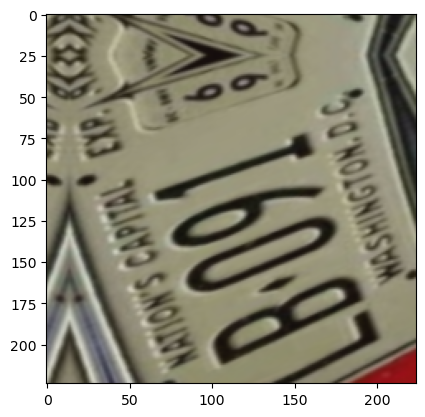

In [20]:
import random

ran = random.randint(0,31)
plt.imshow(images[ran]/255.0)

In [21]:
base_model8 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model8.trainable = False

In [22]:
base_model8.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [25]:
input_layer8 = tf.keras.Input(shape=(224,224,3))

x = base_model8(input_layer8,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

output_layer8 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [26]:
model8 = tf.keras.Model(input_layer8,output_layer8)

In [28]:
model8.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [31]:
model8.fit(train_ds_aug_intense, 
           epochs=25,
           steps_per_epoch=len(train_ds_aug_intense),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model8"),
                      create_modelsave_callback("Model8")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model8
Epoch 1/25
256/256 [==============================] - ETA: 0s - loss: 3.5153 - accuracy: 0.1791
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model8\_01.ckpt
256/256 [==============================] - 34s 102ms/step - loss: 3.5153 - accuracy: 0.1791 - val_loss: 3.4249 - val_accuracy: 0.1679
Epoch 2/25
255/256 [============================>.] - ETA: 0s - loss: 2.8614 - accuracy: 0.3408
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model8\_02.ckpt
256/256 [==============================] - 22s 86ms/step - loss: 2.8613 - accuracy: 0.3408 - val_loss: 3.1898 - val_accuracy: 0.2214
Epoch 3/25
255/256 [============================>.] - ETA: 0s - loss: 2.5612 - accuracy: 0.4113
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model8\_03.ckpt


255/256 [============================>.] - ETA: 0s - loss: 1.3854 - accuracy: 0.6564
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model8\_24.ckpt
256/256 [==============================] - 24s 92ms/step - loss: 1.3854 - accuracy: 0.6564 - val_loss: 2.6344 - val_accuracy: 0.3500
Epoch 25/25
255/256 [============================>.] - ETA: 0s - loss: 1.3544 - accuracy: 0.6641
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model8\_25.ckpt
256/256 [==============================] - 23s 90ms/step - loss: 1.3547 - accuracy: 0.6640 - val_loss: 2.5356 - val_accuracy: 0.3714


# Dropout Rate(0.2) and Learning Rate(0.01) in (Model9) same as Model5

In [32]:
base_model9  = tf.keras.applications.EfficientNetB0(include_top=False)
base_model9.trainable = False

In [33]:
base_model9.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [35]:
input_layer9 = tf.keras.Input(shape=(224,224,3))

x = base_model9(input_layer9,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

output_layer9 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [36]:
model9 = tf.keras.Model(input_layer9,output_layer9)

In [37]:
model9.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["accuracy"])

In [38]:
model9.fit(train_ds_244,
           epochs=75, 
           steps_per_epoch=len(train_ds_244),
           validation_data=valid_ds_224,
           validation_steps=len(valid_ds_224),
           callbacks=[create_tensorboard_callback("Model9"),
                      create_modelsave_callback("Model9")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model9
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 2.9218 - accuracy: 0.3453
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_01.ckpt
256/256 [==============================] - 22s 67ms/step - loss: 2.9223 - accuracy: 0.3453 - val_loss: 2.2573 - val_accuracy: 0.4393
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 1.9320 - accuracy: 0.5360
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.9325 - accuracy: 0.5360 - val_loss: 2.0629 - val_accuracy: 0.5464
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 1.6543 - accuracy: 0.5879
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_03.ckpt
2

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 0.8305 - accuracy: 0.8083
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_48.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 0.8304 - accuracy: 0.8084 - val_loss: 3.0620 - val_accuracy: 0.6357
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 0.8386 - accuracy: 0.8034
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_49.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 0.8385 - accuracy: 0.8035 - val_loss: 3.1850 - val_accuracy: 0.6143
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 0.8391 - accuracy: 0.8066
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_50.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 0.8391 - accuracy: 0.8066 - val_loss: 2

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.8194
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_72.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 0.8025 - accuracy: 0.8194 - val_loss: 3.3329 - val_accuracy: 0.6571
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 0.8284 - accuracy: 0.8163
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_73.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 0.8283 - accuracy: 0.8163 - val_loss: 3.2967 - val_accuracy: 0.6714
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 0.8009 - accuracy: 0.8203
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model9\_74.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 0.8009 - accuracy: 0.8204 - val_loss: 3

# Dropout Rate(0.3)  and Learning Rate(0.01) in Model10 same as Model9

In [39]:
base_model10 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model10.trainable = False

In [41]:
base_model10.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [42]:
input_layer10 = tf.keras.Input(shape=(224,224,3))

x = base_model10(input_layer10,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer10 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [43]:
model10 = tf.keras.Model(input_layer10,output_layer10)

In [44]:
model10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [45]:
model10.fit(train_ds_244,
            epochs=75,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model10"),
                       create_modelsave_callback("Model10")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model10
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 3.0676 - accuracy: 0.3142
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_01.ckpt
256/256 [==============================] - 22s 67ms/step - loss: 3.0673 - accuracy: 0.3143 - val_loss: 2.4511 - val_accuracy: 0.4571
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 2.0940 - accuracy: 0.4993
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 2.0943 - accuracy: 0.4992 - val_loss: 2.2273 - val_accuracy: 0.4929
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 1.8900 - accuracy: 0.5468
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_03.ck

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 1.3811 - accuracy: 0.6939
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_24.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.3809 - accuracy: 0.6939 - val_loss: 2.4658 - val_accuracy: 0.6286
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 1.3484 - accuracy: 0.7027
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_25.ckpt
256/256 [==============================] - 16s 61ms/step - loss: 1.3497 - accuracy: 0.7026 - val_loss: 2.5945 - val_accuracy: 0.6071
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 1.3918 - accuracy: 0.6941
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_26.ckpt
256/256 [==============================] - 16s 61ms/step - loss: 1.3917 - accuracy: 0.6940 - val_loss

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 1.4061 - accuracy: 0.7175
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_48.ckpt
256/256 [==============================] - 16s 61ms/step - loss: 1.4059 - accuracy: 0.7176 - val_loss: 2.8671 - val_accuracy: 0.6393
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 1.3918 - accuracy: 0.7210
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_49.ckpt
256/256 [==============================] - 16s 61ms/step - loss: 1.3920 - accuracy: 0.7209 - val_loss: 3.0655 - val_accuracy: 0.6214
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 1.4196 - accuracy: 0.7181
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_50.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.4195 - accuracy: 0.7182 - val_loss

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 1.4669 - accuracy: 0.7295
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_72.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.4670 - accuracy: 0.7294 - val_loss: 3.1705 - val_accuracy: 0.6464
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 1.5395 - accuracy: 0.7284
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_73.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.5393 - accuracy: 0.7285 - val_loss: 2.9524 - val_accuracy: 0.6571
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 1.4300 - accuracy: 0.7398
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model10\_74.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.4298 - accuracy: 0.7399 - val_loss

# Dropout Rate(0.25) and Learning Rate(0.01) in Model11 same as Model 9

In [47]:
base_model11 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model11.trainable = False

In [50]:
input_layer11 = tf.keras.Input(shape=(224,224,3))

x = base_model11(input_layer11,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)

output_layer11 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [51]:
model11 = tf.keras.Model(input_layer11,output_layer11)

In [52]:
model11.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [53]:
model11.fit(train_ds_244,
            epochs=75,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model11"),
                       create_modelsave_callback("Model11")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model11
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 2.9997 - accuracy: 0.3301
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_01.ckpt
256/256 [==============================] - 22s 69ms/step - loss: 2.9993 - accuracy: 0.3302 - val_loss: 2.4389 - val_accuracy: 0.4714
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 2.0041 - accuracy: 0.5186
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_02.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 2.0039 - accuracy: 0.5187 - val_loss: 1.9917 - val_accuracy: 0.5393
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 1.7272 - accuracy: 0.5819
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_03.ck

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 1.2149 - accuracy: 0.7191
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_24.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.2148 - accuracy: 0.7192 - val_loss: 2.2694 - val_accuracy: 0.6286
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 1.1268 - accuracy: 0.7322
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_25.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.1268 - accuracy: 0.7321 - val_loss: 2.5273 - val_accuracy: 0.6357
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 1.1849 - accuracy: 0.7279
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_26.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 1.1848 - accuracy: 0.7280 - val_loss

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 1.0781 - accuracy: 0.7647
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_48.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.0780 - accuracy: 0.7647 - val_loss: 2.6969 - val_accuracy: 0.6464
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 1.0529 - accuracy: 0.7668
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_49.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.0528 - accuracy: 0.7668 - val_loss: 2.8483 - val_accuracy: 0.6393
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 1.0880 - accuracy: 0.7629
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_50.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 1.0879 - accuracy: 0.7629 - val_loss

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 1.0921 - accuracy: 0.7773
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_72.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 1.0919 - accuracy: 0.7774 - val_loss: 3.1730 - val_accuracy: 0.6500
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 1.1287 - accuracy: 0.7775
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_73.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 1.1286 - accuracy: 0.7775 - val_loss: 3.2695 - val_accuracy: 0.6107
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 1.0819 - accuracy: 0.7739
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model11\_74.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 1.0831 - accuracy: 0.7738 - val_loss

# Dropout Rate(0.275) and Learning Rate(0.01) in Model12 same as Model9

In [13]:
base_model12 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model12.trainable = False

In [14]:
base_model12.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [15]:
input_layer12 = tf.keras.Input(shape=(224,224,3))

x = base_model12(input_layer12,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.275)(x)

output_layer12 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [18]:
model12 = tf.keras.Model(input_layer12,output_layer12)

In [60]:
model12.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [61]:
model12.fit(train_ds_244,
            epochs=75,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model12"),
                       create_modelsave_callback("Model12")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model12
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 2.9584 - accuracy: 0.3299
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_01.ckpt
256/256 [==============================] - 23s 69ms/step - loss: 2.9591 - accuracy: 0.3299 - val_loss: 2.1873 - val_accuracy: 0.4821
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 2.0141 - accuracy: 0.5125
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 2.0143 - accuracy: 0.5124 - val_loss: 2.1553 - val_accuracy: 0.5321
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 1.8374 - accuracy: 0.5538
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_03.ck

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 1.2195 - accuracy: 0.7201
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_24.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.2194 - accuracy: 0.7201 - val_loss: 2.3404 - val_accuracy: 0.6179
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 1.2142 - accuracy: 0.7188
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_25.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.2141 - accuracy: 0.7188 - val_loss: 2.3018 - val_accuracy: 0.6286
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 1.2819 - accuracy: 0.7098
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_26.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.2825 - accuracy: 0.7097 - val_loss

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 1.2463 - accuracy: 0.7404
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_48.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.2461 - accuracy: 0.7405 - val_loss: 2.4679 - val_accuracy: 0.6679
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 1.2536 - accuracy: 0.7375
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_49.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.2535 - accuracy: 0.7375 - val_loss: 2.7574 - val_accuracy: 0.6464
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 1.2436 - accuracy: 0.7397
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_50.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 1.2435 - accuracy: 0.7397 - val_loss

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 1.2686 - accuracy: 0.7567
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_72.ckpt
256/256 [==============================] - 16s 64ms/step - loss: 1.2685 - accuracy: 0.7568 - val_loss: 3.1168 - val_accuracy: 0.6393
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 1.2969 - accuracy: 0.7491
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_73.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.2967 - accuracy: 0.7492 - val_loss: 3.1699 - val_accuracy: 0.6464
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 1.2625 - accuracy: 0.7544
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_74.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 1.2623 - accuracy: 0.7544 - val_loss

# Dropout Rate (0.263) and Learning Rate(0.01) in Model13 same as Model9

In [62]:
base_model13 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model13.trainable = False

In [63]:
base_model13.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_12 (Rescaling)       (None, None, None,   0           ['input_16[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_6 (Normalization  (None, None, None,   7          ['rescaling_12[0][0]']           
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [64]:
input_layer13 = tf.keras.Input(shape=(224,224,3))

x = base_model13(input_layer13,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.263)(x)

output_layer13 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [65]:
model13 = tf.keras.Model(input_layer13,output_layer13)

In [66]:
model13.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [67]:
model13.fit(train_ds_244,
            epochs=75,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224), 
            callbacks=[create_tensorboard_callback("Model13"),
                       create_modelsave_callback("Model13")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model13
Epoch 1/75
255/256 [============================>.] - ETA: 0s - loss: 3.0329 - accuracy: 0.3233
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_01.ckpt
256/256 [==============================] - 23s 71ms/step - loss: 3.0330 - accuracy: 0.3232 - val_loss: 2.3521 - val_accuracy: 0.4857
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 2.0795 - accuracy: 0.5043
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_02.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 2.0792 - accuracy: 0.5043 - val_loss: 2.2664 - val_accuracy: 0.5000
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 1.7596 - accuracy: 0.5694
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_03.ck

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 1.1771 - accuracy: 0.7188
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_24.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 1.1770 - accuracy: 0.7188 - val_loss: 2.4356 - val_accuracy: 0.6071
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 1.1811 - accuracy: 0.7249
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_25.ckpt
256/256 [==============================] - 16s 61ms/step - loss: 1.1810 - accuracy: 0.7249 - val_loss: 2.5019 - val_accuracy: 0.6000
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 1.1741 - accuracy: 0.7273
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_26.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 1.1739 - accuracy: 0.7274 - val_loss

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 1.2095 - accuracy: 0.7434
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_48.ckpt
256/256 [==============================] - 17s 64ms/step - loss: 1.2093 - accuracy: 0.7434 - val_loss: 2.7896 - val_accuracy: 0.6607
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 1.1333 - accuracy: 0.7512
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_49.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 1.1332 - accuracy: 0.7513 - val_loss: 2.7632 - val_accuracy: 0.6643
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 1.1781 - accuracy: 0.7496
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_50.ckpt
256/256 [==============================] - 16s 62ms/step - loss: 1.1780 - accuracy: 0.7497 - val_loss

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 1.1413 - accuracy: 0.7683
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_72.ckpt
256/256 [==============================] - 21s 82ms/step - loss: 1.1413 - accuracy: 0.7683 - val_loss: 3.1382 - val_accuracy: 0.6643
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 1.2291 - accuracy: 0.7591
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_73.ckpt
256/256 [==============================] - 22s 84ms/step - loss: 1.2289 - accuracy: 0.7591 - val_loss: 3.1574 - val_accuracy: 0.6321
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 1.1680 - accuracy: 0.7733
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model13\_74.ckpt
256/256 [==============================] - 20s 77ms/step - loss: 1.1695 - accuracy: 0.7732 - val_loss

# Dropout Rate(0.275) and learning rate(0.02) in Model14 same as Model9

In [7]:
base_model14 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model14.trainable = False

In [8]:
base_model14.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [9]:
input_layer14 = tf.keras.Input(shape=(224,224,3))

x = base_model14(input_layer14,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.275)(x)

output_layer14 = tf.keras.layers.Dense(56,activation="softmax")(x)

In [10]:
model14 = tf.keras.Model(input_layer14,output_layer14)

In [11]:
model14.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                metrics=["accuracy"])

In [12]:
model14.fit(train_ds_244,
            epochs=75,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224), 
            callbacks=[create_tensorboard_callback("Model14"),
                       create_modelsave_callback("Model14")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model14
Epoch 1/75
256/256 [==============================] - ETA: 0s - loss: 3.7237 - accuracy: 0.3043
Epoch 1: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_01.ckpt
256/256 [==============================] - 36s 74ms/step - loss: 3.7237 - accuracy: 0.3043 - val_loss: 3.1755 - val_accuracy: 0.4464
Epoch 2/75
255/256 [============================>.] - ETA: 0s - loss: 2.7636 - accuracy: 0.4738
Epoch 2: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_02.ckpt
256/256 [==============================] - 16s 63ms/step - loss: 2.7633 - accuracy: 0.4738 - val_loss: 2.9485 - val_accuracy: 0.4964
Epoch 3/75
255/256 [============================>.] - ETA: 0s - loss: 2.6209 - accuracy: 0.5140
Epoch 3: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_03.ck

Epoch 24/75
255/256 [============================>.] - ETA: 0s - loss: 2.2941 - accuracy: 0.6833
Epoch 24: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_24.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 2.2943 - accuracy: 0.6832 - val_loss: 4.1483 - val_accuracy: 0.5964
Epoch 25/75
255/256 [============================>.] - ETA: 0s - loss: 2.4316 - accuracy: 0.6817
Epoch 25: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_25.ckpt
256/256 [==============================] - 17s 65ms/step - loss: 2.4322 - accuracy: 0.6817 - val_loss: 4.0543 - val_accuracy: 0.6143
Epoch 26/75
255/256 [============================>.] - ETA: 0s - loss: 2.4496 - accuracy: 0.6776
Epoch 26: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_26.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 2.4493 - accuracy: 0.6776 - val_loss

Epoch 48/75
255/256 [============================>.] - ETA: 0s - loss: 2.3148 - accuracy: 0.7200
Epoch 48: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_48.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 2.3156 - accuracy: 0.7199 - val_loss: 4.7539 - val_accuracy: 0.6429
Epoch 49/75
255/256 [============================>.] - ETA: 0s - loss: 2.4639 - accuracy: 0.7169
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_49.ckpt
256/256 [==============================] - 17s 67ms/step - loss: 2.4636 - accuracy: 0.7169 - val_loss: 4.9082 - val_accuracy: 0.6179
Epoch 50/75
255/256 [============================>.] - ETA: 0s - loss: 2.2830 - accuracy: 0.7312
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_50.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 2.2835 - accuracy: 0.7312 - val_loss

Epoch 72/75
255/256 [============================>.] - ETA: 0s - loss: 2.3617 - accuracy: 0.7401
Epoch 72: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_72.ckpt
256/256 [==============================] - 18s 68ms/step - loss: 2.3614 - accuracy: 0.7401 - val_loss: 5.6307 - val_accuracy: 0.6286
Epoch 73/75
255/256 [============================>.] - ETA: 0s - loss: 2.5842 - accuracy: 0.7275
Epoch 73: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_73.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 2.5842 - accuracy: 0.7274 - val_loss: 5.7478 - val_accuracy: 0.6250
Epoch 74/75
255/256 [============================>.] - ETA: 0s - loss: 2.5608 - accuracy: 0.7243
Epoch 74: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model14\_74.ckpt
256/256 [==============================] - 17s 66ms/step - loss: 2.5605 - accuracy: 0.7243 - val_loss

# Fine-Tuning Model12 at 26th epoch with Top 20 Layers Unfreeze

In [30]:
base_model12.trainable = True

In [31]:
for layer in base_model12.layers[:-20]:
    layer.trainable = False

In [32]:
base_model12.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 1,350,960
Non-trainable params: 2,698,611
__________________________________________________________________________________________________


In [33]:
len(base_model12.trainable_variables)

19

In [34]:
model12.load_weights(r"D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_26.ckpt")

In [37]:
model12.evaluate(train_ds_244)

256/256 [==============================] - 15s 57ms/step - loss: 0.3571 - accuracy: 0.8973


[0.3570634424686432, 0.8973165154457092]

In [35]:
model12.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [38]:
model12.fit(train_ds_244,
            initial_epoch=26,
            epochs=50,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model12finetune1fg"),
                       create_modelsave_callback("Model12finetune1fg")]) 

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model12finetune1fg
Epoch 27/50
255/256 [============================>.] - ETA: 0s - loss: 1.7051 - accuracy: 0.6239
Epoch 27: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune1fg\_27.ckpt
256/256 [==============================] - 23s 70ms/step - loss: 1.7058 - accuracy: 0.6238 - val_loss: 1.9054 - val_accuracy: 0.6714
Epoch 28/50
255/256 [============================>.] - ETA: 0s - loss: 0.8362 - accuracy: 0.7912
Epoch 28: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune1fg\_28.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 0.8361 - accuracy: 0.7912 - val_loss: 1.6048 - val_accuracy: 0.6893
Epoch 29/50
255/256 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8855
Epoch 29: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Quest

255/256 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9741
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune1fg\_49.ckpt
256/256 [==============================] - 18s 72ms/step - loss: 0.0883 - accuracy: 0.9741 - val_loss: 1.5659 - val_accuracy: 0.7929
Epoch 50/50
255/256 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9754
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune1fg\_50.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 0.0824 - accuracy: 0.9754 - val_loss: 1.3163 - val_accuracy: 0.7893


In [39]:
model12.evaluate(valid_ds_224)

9/9 [==============================] - 1s 53ms/step - loss: 1.3163 - accuracy: 0.7893


[1.3163021802902222, 0.7892857193946838]

In [40]:
model12.evaluate(test_ds_224)

9/9 [==============================] - 2s 54ms/step - loss: 1.2692 - accuracy: 0.7429


[1.2691853046417236, 0.7428571581840515]

In [41]:
model12.load_weights(r"D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_26.ckpt")

In [42]:
model12.evaluate(valid_ds_224)

9/9 [==============================] - 1s 53ms/step - loss: 2.2834 - accuracy: 0.6679


[2.283437490463257, 0.6678571701049805]

In [43]:
model12.evaluate(test_ds_224)

9/9 [==============================] - 1s 54ms/step - loss: 2.4941 - accuracy: 0.6036


[2.4941368103027344, 0.6035714149475098]

In [44]:
model12.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

In [45]:
model12.fit(train_ds_244,
            epochs=50,
            initial_epoch=26,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model12finetune2"),
                       create_modelsave_callback("Model12finetune2")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model12finetune2
Epoch 27/50
255/256 [============================>.] - ETA: 0s - loss: 1.1227 - accuracy: 0.7254
Epoch 27: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune2\_27.ckpt
256/256 [==============================] - 24s 74ms/step - loss: 1.1229 - accuracy: 0.7253 - val_loss: 2.3389 - val_accuracy: 0.6357
Epoch 28/50
255/256 [============================>.] - ETA: 0s - loss: 0.6982 - accuracy: 0.8161
Epoch 28: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune2\_28.ckpt
256/256 [==============================] - 18s 70ms/step - loss: 0.6981 - accuracy: 0.8161 - val_loss: 1.8588 - val_accuracy: 0.6929
Epoch 29/50
255/256 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.8996
Epoch 29: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\Mo

256/256 [==============================] - 18s 71ms/step - loss: 0.0535 - accuracy: 0.9813 - val_loss: 1.5464 - val_accuracy: 0.7893
Epoch 50/50
255/256 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9831
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune2\_50.ckpt
256/256 [==============================] - 18s 71ms/step - loss: 0.0517 - accuracy: 0.9831 - val_loss: 1.8000 - val_accuracy: 0.7929


In [46]:
model12.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 56)                71736     
                                                                 
Total params: 4,121,307
Trainable params: 1,422,696
Non-trainable params: 2,698,611
_________________________________________

In [48]:
base_model12.trainable=True

In [49]:
base_model12.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
__________________________________________________________________________________________________


In [50]:
model12.load_weights(r"D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_26.ckpt")

In [51]:
model12.evaluate(valid_ds_224)

9/9 [==============================] - 1s 54ms/step - loss: 2.2834 - accuracy: 0.6679


[2.283437490463257, 0.6678571701049805]

In [52]:
model12.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 56)                71736     
                                                                 
Total params: 4,121,307
Trainable params: 4,079,284
Non-trainable params: 42,023
____________________________________________

In [53]:
model12.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [54]:
model12.fit(train_ds_244,
            initial_epoch=26,
            epochs=50,
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model12finetune3"),
                       create_modelsave_callback("Model12finetune3")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model12finetune3
Epoch 27/50
256/256 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.7868
Epoch 27: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune3\_27.ckpt
256/256 [==============================] - 64s 218ms/step - loss: 0.8428 - accuracy: 0.7868 - val_loss: 1.7707 - val_accuracy: 0.7036
Epoch 28/50
256/256 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.8775
Epoch 28: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune3\_28.ckpt
256/256 [==============================] - 53s 208ms/step - loss: 0.4313 - accuracy: 0.8775 - val_loss: 1.7773 - val_accuracy: 0.7214
Epoch 29/50
256/256 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9219
Epoch 29: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\

256/256 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9902
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune3\_49.ckpt
256/256 [==============================] - 58s 225ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 1.1779 - val_accuracy: 0.8607
Epoch 50/50
256/256 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9942
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune3\_50.ckpt
256/256 [==============================] - 56s 219ms/step - loss: 0.0204 - accuracy: 0.9942 - val_loss: 1.2007 - val_accuracy: 0.8393


In [55]:
model12.load_weights(r"D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12\_26.ckpt")

In [56]:
base_model12.trainable=True

In [57]:
base_model12.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
__________________________________________________________________________________________________


In [58]:
model12.evaluate(valid_ds_224)

9/9 [==============================] - 1s 53ms/step - loss: 2.2834 - accuracy: 0.6679


[2.283437490463257, 0.6678571701049805]

In [59]:
model12.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=["accuracy"])

In [60]:
model12.fit(train_ds_244,
            epochs=50,
            initial_epoch=26,
            steps_per_epoch=len(train_ds_244),
            validation_data=valid_ds_224,
            validation_steps=len(valid_ds_224),
            callbacks=[create_tensorboard_callback("Model12finetune4"),
                       create_modelsave_callback("Model12finetune4")])

Created TensorBoard Callback :- D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\TensorBoardCallback\Model12finetune4
Epoch 27/50
256/256 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.8057
Epoch 27: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune4\_27.ckpt
256/256 [==============================] - 63s 217ms/step - loss: 0.7454 - accuracy: 0.8057 - val_loss: 1.9645 - val_accuracy: 0.6857
Epoch 28/50
256/256 [==============================] - ETA: 0s - loss: 0.5723 - accuracy: 0.8446
Epoch 28: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune4\_28.ckpt
256/256 [==============================] - 53s 208ms/step - loss: 0.5723 - accuracy: 0.8446 - val_loss: 1.8861 - val_accuracy: 0.6964
Epoch 29/50
256/256 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.8636
Epoch 29: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\

256/256 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9745
Epoch 49: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune4\_49.ckpt
256/256 [==============================] - 60s 233ms/step - loss: 0.0768 - accuracy: 0.9745 - val_loss: 1.6746 - val_accuracy: 0.7750
Epoch 50/50
256/256 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9786
Epoch 50: saving model to D:\CNNtest\MAIN_WORK_FOLDER\Number_Plate_Question\ModelSaveCheckPoints\Model12finetune4\_50.ckpt
256/256 [==============================] - 59s 228ms/step - loss: 0.0690 - accuracy: 0.9786 - val_loss: 1.6655 - val_accuracy: 0.7679
